# Exercise 2 - Deformable Image Registration

### Task 1  - Image gradients and diffusion regularisation 

At first we import relevant python functions. Functions for laplace matrices, conjugate gradients as well as a function for visualizing deformation fields are given.

In [1]:
import math

import torch
import torch.nn as nn

import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors as mcolors
import scipy.io


def laplace(lambda_weight,H,W):
    xy = torch.arange(H*W).view(H,W)
    i1 = torch.cat((xy[1:,:].view(1,-1),xy[:-1,:].view(1,-1)),0)
    i2 = torch.cat((xy[:-1,:].view(1,-1),xy[1:,:].view(1,-1)),0)
    i3 = torch.cat((xy[:,1:].contiguous().view(1,-1),xy[:,:-1].contiguous().view(1,-1)),0)
    i4 = torch.cat((xy[:,:-1].contiguous().view(1,-1),xy[:,1:].contiguous().view(1,-1)),0)

    A = lambda_weight * torch.sparse.FloatTensor(torch.cat((i1,i2,i3,i4),1), -torch.ones(2*(2*H*W-H-W)), torch.Size([H*W,H*W]))#
    D = torch.spmm(A,-torch.ones(H*W,1)).view(-1)# + diag.view(-1) #row-sum + input diagonal
    D = torch.sparse.FloatTensor(torch.stack((torch.arange(H*W),torch.arange(H*W)),0), D, torch.Size([H*W,H*W]))
    L = D + A 
    return L

def sparseCG(A,b,iterations): #A sparse matrix, b dense vector
#conjugate gradient https://william-dawson.github.io/blog/method/2017/10/01/matrixcg.html
    x = torch.zeros(b.numel(),1)
    r = b.view(-1,1) - torch.spmm(A,x)
    p = r.clone()
    for i in range(iterations):
        Ap = torch.spmm(A,p)
        top = (r*r).sum()
        bottom = (p*Ap).sum()
        alpha = top / bottom
        x = x + alpha * p
        r = r - alpha * Ap

        #norm_value = torch.norm(r)
        #if norm_value < 1e-8:
        #    break
        new_top = (r*r).sum()
        beta = new_top/top
        p = r + beta * p
    #print("Done:", i, norm_value)
    return x

# showFlow: transforms deformation field into a rgb image
# input: numpy.array, H x W x C(numdims), should be on cpu (check with def_x.device)
def showFlow(def_x):
    x = def_x.squeeze().numpy()[0,:,:]
    y = def_x.squeeze().numpy()[1,:,:]
    #show flow map for numpy
    H, W = x.shape
    rho = np.sqrt(x*x+y*y)
    theta = np.arctan2(x,-y)
    theta2 = (-theta+np.pi)/(2.0*np.pi)
    rho = np.clip(rho/np.percentile(rho, 99),0,1)
    hsv = np.stack((theta2,rho,np.ones((H,W))),axis=2)
    rgb = mcolors.hsv_to_rgb(hsv)
    return rgb



In [2]:
# Load and reformat input data (fixed and moving image)

images = torch.load('images_flow.pth')
fixed = images[0:1].unsqueeze(1)
moving = images[1:2].unsqueeze(1)

In [3]:
"""
Solution by: Falco Lentzsch(685454),Konrad von Kuegelgen, Jesse Kruse(675710)
"""

'\nSolution by: Falco Lentzsch(685454),Konrad von Kuegelgen, Jesse Kruse(675710)\n'

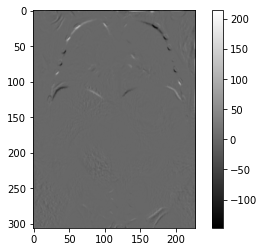

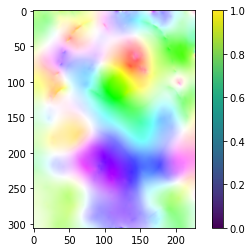

In [4]:
# Implement tasks 1 & 2
'''
Hier started Aufgabe 1
'''

# H und W auslesen
H,W = fixed.size()[-2:]
# Größe des Bildes erstellen
xy = torch.arange(H*W)
# Größe für Sparse Matrix
size = (H * W, H * W)
# Indices für Diagonale auf Sparse Matrix
indices = torch.stack([xy,xy],0)
# Gewichtungsfaktor für La Place Matrix
lambda_weight = 750
# generate laplace matrix (given)
L = laplace(lambda_weight, H, W)

# todo: calculate the two-point stencil
weight = torch.linspace(-.5, .5, 3)
Mx_weights = weight.view(1, 1, 1, 3)
My_weights = weight.view(1, 1, 3, 1)

# Moving Image wird gepadded, damit die Größe gleich bleibt durch die Faltung
Mx_pad_input = F.pad(moving, [1, 1, 0, 0], 'replicate')
My_pad_input = F.pad(moving, [0, 0, 1, 1], 'replicate')

# Bild filtern in x und y Richtung liefert Gradientenfeld
Mx_gradient = F.conv2d(input=Mx_pad_input,weight=Mx_weights)
My_gradient = F.conv2d(input=My_pad_input,weight=My_weights)

# Gradientenfeld als Vektor und quadriert
Mx_gradient_diag_squared = torch.pow(Mx_gradient.view(-1), 2)
My_gradient_diag_squared = torch.pow(My_gradient.view(-1), 2)

# Eintragen der quadrierten Gradienten auf der Diagonalen unserer Sparse Matrix
Mxx = torch.sparse_coo_tensor(indices=indices,values=Mx_gradient_diag_squared,size=size)
Myy = torch.sparse_coo_tensor(indices=indices,values=My_gradient_diag_squared,size=size)

# Rechte Seite der Gleichung wird erstellt
# MM zwischen L und u fällt weg, da u^0 = 0
bx = -(moving-fixed) * Mx_gradient
by = -(moving-fixed) * My_gradient

# todo: create vectors u,v --> Verschiebungsfeld
u = sparseCG(L + Mxx, bx, 25).view(H, W)
v = sparseCG(L + Myy, by, 25).view(H, W)


'''
Hier started Aufgabe 2
'''
# generate identity grid using F.affine_grid
# Erstellen hier ein Grid mit 6 Freiheitsgraden wobei wir es
# Standartmäßig so initialisieren, das das grid nichts verändert
identity_grid = F.affine_grid(torch.eye(2, 3).unsqueeze(0), [1, 1, H, W], True)
# stacked and reshaped uv im Bereich zwischen -1 und 1
uv = torch.stack([u / (.5 * (H - 1)), v / (.5 * (W - 1))], 2).unsqueeze(0)

# Addieren von UV udn Grid liefert ein Transformationsfeld
mapped_uv_field = identity_grid + uv
warped = F.grid_sample(moving, mapped_uv_field, align_corners=True)

# For-loop for iterative warping
for i in range(10):
    # Padding des warped Bildes nicht, da neues moving image
    Mx_pad_input = F.pad(warped, [1, 1, 0, 0], 'replicate')
    My_pad_input = F.pad(warped, [0, 0, 1, 1], 'replicate')
    # todo: Apply the gradient filter using 2d-convolution
    Mx_gradient = F.conv2d(input=Mx_pad_input,weight=Mx_weights)
    My_gradient = F.conv2d(input=My_pad_input,weight=My_weights)


    # Gradientenfeld als Vektor und quadriert
    Mx_gradient_diag_squared = torch.pow(Mx_gradient.view(-1), 2)
    My_gradient_diag_squared = torch.pow(My_gradient.view(-1), 2)

    # todo: Create Sparse Matrices containing pointwise squared gradients
    # Eintragen der quadrierten Gradienten auf der Diagonalen unserer Sparse Matrix
    Mxx = torch.sparse_coo_tensor(indices=indices,values=Mx_gradient_diag_squared,size=size)
    Myy = torch.sparse_coo_tensor(indices=indices,values=My_gradient_diag_squared,size=size)

    # todo: Create tensors bx,by
    # Rechte Seite der Gleichung wird erstellt
    #bx = -(warped-fixed) * Mx_gradient
    #by = -(warped-fixed) * My_gradient
    bx = - torch._sparse_mm(L, u.view(-1, 1)).view(H, W) -(warped - fixed) * Mx_gradient
    by = - torch._sparse_mm(L, v.view(-1, 1)).view(H, W) -(warped - fixed) * My_gradient

    # todo: Solve u,v (separately) and stack accordingly to uv
    u += sparseCG(L + Mxx, bx, 25).view(H, W)
    v += sparseCG(L + Myy, by, 25).view(H, W)
    uv = torch.stack([u / (.5 * (H - 1)), v / (.5 * (W - 1))], 2).unsqueeze(0)

    # todo: warp Image using F:grid_sample with identity grid (task 2)
    mapped_uv_field = identity_grid + uv
    warped = F.grid_sample(moving, mapped_uv_field, align_corners=True)

'''
Visualisierung
'''

plt.imshow((fixed-warped).squeeze().numpy(),'gray')
plt.colorbar()
plt.show()
rgb = showFlow(torch.stack((u,v),0))

plt.imshow(rgb)
plt.colorbar()
plt.show()

Loss in Epoche  0 : tensor(26559758.)
Loss in Epoche  1 : tensor(21791710.)
Loss in Epoche  2 : tensor(11251186.)
Loss in Epoche  3 : tensor(10231012.)
Loss in Epoche  4 : tensor(10211704.)
Loss in Epoche  5 : tensor(7894290.)
Loss in Epoche  6 : tensor(6198828.)
Loss in Epoche  7 : tensor(5969419.5000)
Loss in Epoche  8 : tensor(5860547.)
Loss in Epoche  9 : tensor(5602091.)
Loss in Epoche  10 : tensor(5505267.5000)
Loss in Epoche  11 : tensor(5322766.5000)
Loss in Epoche  12 : tensor(4889057.5000)
Loss in Epoche  13 : tensor(4293974.)
Loss in Epoche  14 : tensor(3775606.7500)
Loss in Epoche  15 : tensor(3506724.7500)
Loss in Epoche  16 : tensor(3538618.5000)
Loss in Epoche  17 : tensor(3587912.7500)
Loss in Epoche  18 : tensor(3434751.2500)
Loss in Epoche  19 : tensor(3037813.)
Loss in Epoche  20 : tensor(2646004.5000)
Loss in Epoche  21 : tensor(2554960.5000)
Loss in Epoche  22 : tensor(2639419.5000)
Loss in Epoche  23 : tensor(2640752.2500)
Loss in Epoche  24 : tensor(2449488.7500)

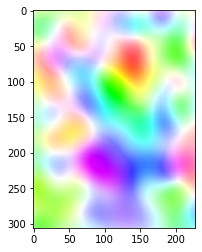

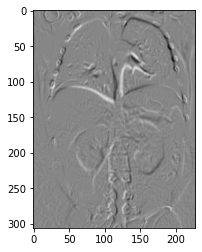

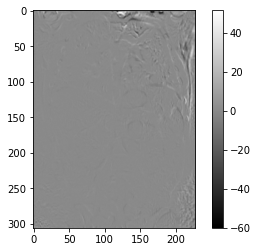

In [5]:
class DeformableNet(nn.Module):
    def __init__(self):
        super(DeformableNet, self).__init__()
        self.a = nn.Parameter(0.0*torch.randn(1,2,51,38))
        self.bspline = nn.Sequential(
            nn.ZeroPad2d(6),
            nn.AvgPool2d(5,stride=1),
            nn.AvgPool2d(5,stride=1),
            nn.AvgPool2d(5,stride=1))


    def forward(self):
        x = self.bspline(self.a)
        return F.interpolate(x,scale_factor=6,mode='bilinear',align_corners=True)

net = DeformableNet()
disp_x = net()

H,W = fixed.size()[-2:]

# todo: create identity grid
identity_grid = F.affine_grid(torch.eye(2, 3).unsqueeze(0), [1, 1, H, W], True)

# given: initialization of adam and bspline definition
optimizer = torch.optim.Adam(net.parameters(),lr=0.015)
#bspline = nn.Sequential(nn.ZeroPad2d(6),nn.AvgPool2d(5,stride=1),nn.AvgPool2d(5,stride=1),nn.AvgPool2d(5,stride=1))



# Defintion of NCC los
# given: weights, mean and variance for fixed image
K = 5
kw = (K-1)//2
N = F.avg_pool2d(torch.ones_like(moving),K,stride=1,padding=kw).sum()
fixed_mean = F.avg_pool2d(fixed,K,stride=1,padding=kw)/N
fixed_var = F.avg_pool2d(fixed**2,K,stride=1,padding=kw)/N-fixed_mean**2

def NCC(moving_image):
    moving = moving_image
    moving_mean = F.avg_pool2d(moving,K,stride=1,padding=kw)/N
    moving_var = F.avg_pool2d(moving**2,K,stride=1,padding=kw)/N-moving_mean**2


    cov = (F.avg_pool2d(moving,K,stride=1,padding=kw) - moving_mean) \
          * (F.avg_pool2d(fixed,K,stride=1,padding=kw) - fixed_mean)

    # soll laut Übung so gemacht werden
    cov_2 = F.avg_pool2d(moving * fixed,K,stride=1,padding=kw) \
          - F.avg_pool2d(moving,K,stride=1,padding=kw) * fixed_mean \
          - moving_mean * (F.avg_pool2d(fixed,K,stride=1,padding=kw)) \
          + moving_mean * fixed_mean

    # zur aufgabe aller bilder
    #plt.imshow(torch.sqrt(fixed_var).cpu().squeeze(),'gray')
    #plt.show()

    #covariance = avg_kernel(moving * fixed) - avg_kernel(moving) * fixed_mean \
                #- avg_kernel(fixed) * moving_mean + moving_mean * fixed_mean
    # https://stackoverflow.com/questions/40050397/deep-learning-nan-loss-reasons
    # cov wird hier quadriert, da die ganze Gleichung quadriert werden soll
    # die beiden Varianzen sollten eigtl in der Formel Standartabweichungensein.
    # Da wir aber quadrieren sollen, lassen wir diese hier so
    # 1e-8 bei Stackoverflow nach zu lesen, damit es nicht passieren kann das wir durch 0 Teilen.
    ncc =  - torch.sum(cov_2.pow(2) / (moving_var * fixed_var))

    return ncc


# definde loss
mse_Loss = nn.MSELoss(reduction='sum')


# given: Optimisation loop
for i in range(0,100):
    # todo: Reset gradients
    optimizer.zero_grad()

    # given :Execute the model to obtain displacements
    disp_x = net()
    # todo: call function for bilinear upsampling (scaling of 6)

    # todo: Warp image
    mapped_uv_field = identity_grid + disp_x.permute(0,2,3,1)
    warped = F.grid_sample(moving, mapped_uv_field, align_corners=True)

    # todo: Compute Mean Squared Error for loss criteria

    loss = mse_Loss(warped, fixed) # --> use this for MSE
    #loss = NCC(warped) # --> use this for NCC
    print("Loss in Epoche ", i , ":", loss.data)

    # todo: (Bonus) Compute Normalised Cross Correlation for loss criteria

    # todo: Compute gradients of the loss w.r.t. the parameters of our model (-> backward).
    loss.backward()
    # todo: Update the parameters based on the calculated gradients.
    optimizer.step()
# Visualization
rgb_nn = showFlow(disp_x.data.cpu())
plt.imshow(rgb_nn)
plt.show()

warped = F.grid_sample(moving,disp_x.permute(0,2,3,1)+identity_grid,align_corners=True,padding_mode='border')
plt.imshow((moving-fixed).data.cpu().squeeze(),'gray')
plt.show()
plt.imshow((warped-fixed).data.cpu().squeeze(),'gray')
plt.colorbar()
plt.show()